In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
import json
from tqdm import tqdm

from gtfparse import read_gtf
import anndata


In [9]:

fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'


value_to_predict = 'Sex'

In [13]:
def read_geuvadis(fname_data: Path | str,
                  fname_header: Path | str,
                  fname_gtf: Path | str):
    data_raw = pd.read_csv(fname_data, index_col=0).T
    data_raw = data_raw.astype(np.float32)

    data_header = pd.read_csv(fname_header, index_col=0)

    gtf_rawdata = read_gtf(fname_gtf)
    gtf_data = gtf_rawdata.to_pandas()
    gtf_data = gtf_data.set_index('transcript_id')
    gtf_data['transcript_id'] = gtf_data.index

    gtf_data = gtf_data.drop_duplicates("transcript_id")

    print('Dataset shape: ', data_raw.shape)

    return data_raw, data_header, gtf_data

data_raw, data_header, gtf_data = read_geuvadis(
    fdir_raw / 'Geuvadis.all.csv',
    fdir_raw / 'Geuvadis.SraRunTable.txt',
    fdir_raw / 'all_transcripts_strigtie_merged.gtf'
)

data_raw = data_raw[data_raw.columns.intersection(gtf_data.index)]
gtf_data = gtf_data.loc[data_raw.columns.intersection(gtf_data.index)]

adata = anndata.AnnData(data_raw)
adata.var = gtf_data
adata.obs = data_header

adata

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


Dataset shape:  (667, 338725)


AnnData object with n_obs × n_vars = 667 × 338725
    obs: 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Broker_name', 'Bytes', 'Center Name', 'common_name', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'ENA-FIRST-PUBLIC (run)', 'ena_first_public', 'ENA-LAST-UPDATE (run)', 'ENA_last_update', 'Experiment', 'Experimental_Factor:_laboratory (exp)', 'Experimental_Factor:_population (exp)', 'external_id', 'INSDC_center_alias', 'INSDC_center_name', 'INSDC_first_public', 'INSDC_last_update', 'INSDC_status', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'Organism', 'Platform', 'population', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Sample_name', 'SRA Study', 'strain', 'Submitter_Id', 'Sample', 'Sex'
    var: 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id', 'exon_number', 'gene_name', 'ref_gene_id', 'transcript_id'

In [14]:
transcripts_dict = {}
transcripts_list = []
for organ_name in ['BRAIN0', "HEART", "BRAIN1", 'None']:
    
    if organ_name == "None":
        organ = "BLOOD"
    else:
        organ = organ_name
    transcripts_dict[organ] = {}

    for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:
        features_fname = f"geuvadis_train_features_{sex}_calibration_{organ_name}.csv"
        features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)
        
        transcripts_dict[organ][sex] = features_list.index
        
        transcripts_list.extend(features_list.index.tolist())
        # print(features_list)
transcripts_list = list(set(transcripts_list))

In [15]:
features_fname = f"geuvadis_train_features_{'chrY'}_calibration_{'None'}.csv"
features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)
print(ml_models_fdir / model_type / features_fname)
features_list

../models/xgboost/geuvadis_train_features_chrY_calibration_None.csv


,SHAP
Feature,
MSTRG.36720.1,48
MSTRG.22356.8,46
MSTRG.22373.18,46


In [16]:
from supervenn import supervenn
from upsetplot import plot, UpSet, from_contents

# example = generate_counts()
# plot(example)
# example

In [17]:
import itertools

for organ in ['BRAIN0', "HEART", "BRAIN1", 'BLOOD']:
    transcripts_dict[organ]['chrXY']

# for key1, key2 in list(itertools.combinations(['BRAIN0', "HEART", "BRAIN1", 'None'], 2)):
#     transcripts_dict[key1]['chrXY'].union(transcripts_dict[key2]['chrXY'])



In [18]:
transcripts_dict
transcripts_dict['BLOOD']['chrY']
# 
features_list

,SHAP
Feature,
MSTRG.36720.1,48
MSTRG.22356.8,46
MSTRG.22373.18,46


In [19]:
adata.var['gene_name']

ENST00000378604.3     CALML6
ENST00000307786.8     CALML6
ENST00000482402.1     CALML6
ENST00000462293.1     CALML6
ENST00000378602.3     TMEM52
                      ...   
ENST00000420810.1    CYCSP49
ENST00000431853.1    CTBP2P1
ENST00000711259.1     DPH3P2
ENST00000711266.1    ELOCP24
ENST00000711267.1    TRPC6P1
Name: gene_name, Length: 338725, dtype: object

Chromosomes:  chrY
['train: BLOOD, test: BRAIN0' 'train: BLOOD, test: HEART'] : 
{'ENST00000565196.5', 'MSTRG.13450.7', 'ENST00000494573.6', 'ENST00000392249.6', 'ENST00000589005.5', 'ENST00000300184.8', 'ENST00000548200.5', 'MSTRG.3806.9', 'ENST00000413366.8', 'MSTRG.31758.3', 'ENST00000375200.6', 'ENST00000337338.9', 'ENST00000246080.4', 'MSTRG.14482.3', 'MSTRG.27773.6', 'MSTRG.26990.1', 'MSTRG.9085.27', 'ENST00000507765.1', 'MSTRG.1873.42', 'ENST00000645860.1', 'ENST00000476438.1', 'MSTRG.2400.4', 'ENST00000581584.5', 'MSTRG.28032.1', 'ENST00000367718.5', 'ENST00000651342.1', 'ENST00000472755.2', 'MSTRG.17052.1', 'MSTRG.1692.7', 'ENST00000460903.2', 'ENST00000372476.8', 'MSTRG.21565.11', 'MSTRG.20714.15', 'ENST00000372583.6', 'MSTRG.21565.12', 'MSTRG.26895.13', 'MSTRG.22004.4', 'ENST00000624344.1', 'MSTRG.2288.7', 'MSTRG.3529.27', 'MSTRG.23851.1', 'MSTRG.1168.1', 'ENST00000303115.8'}
['train: BLOOD, test: BRAIN0'] : 
{'ENST00000308831.7', 'ENST00000420217.1', 'MSTRG.12050.13', 'ENST

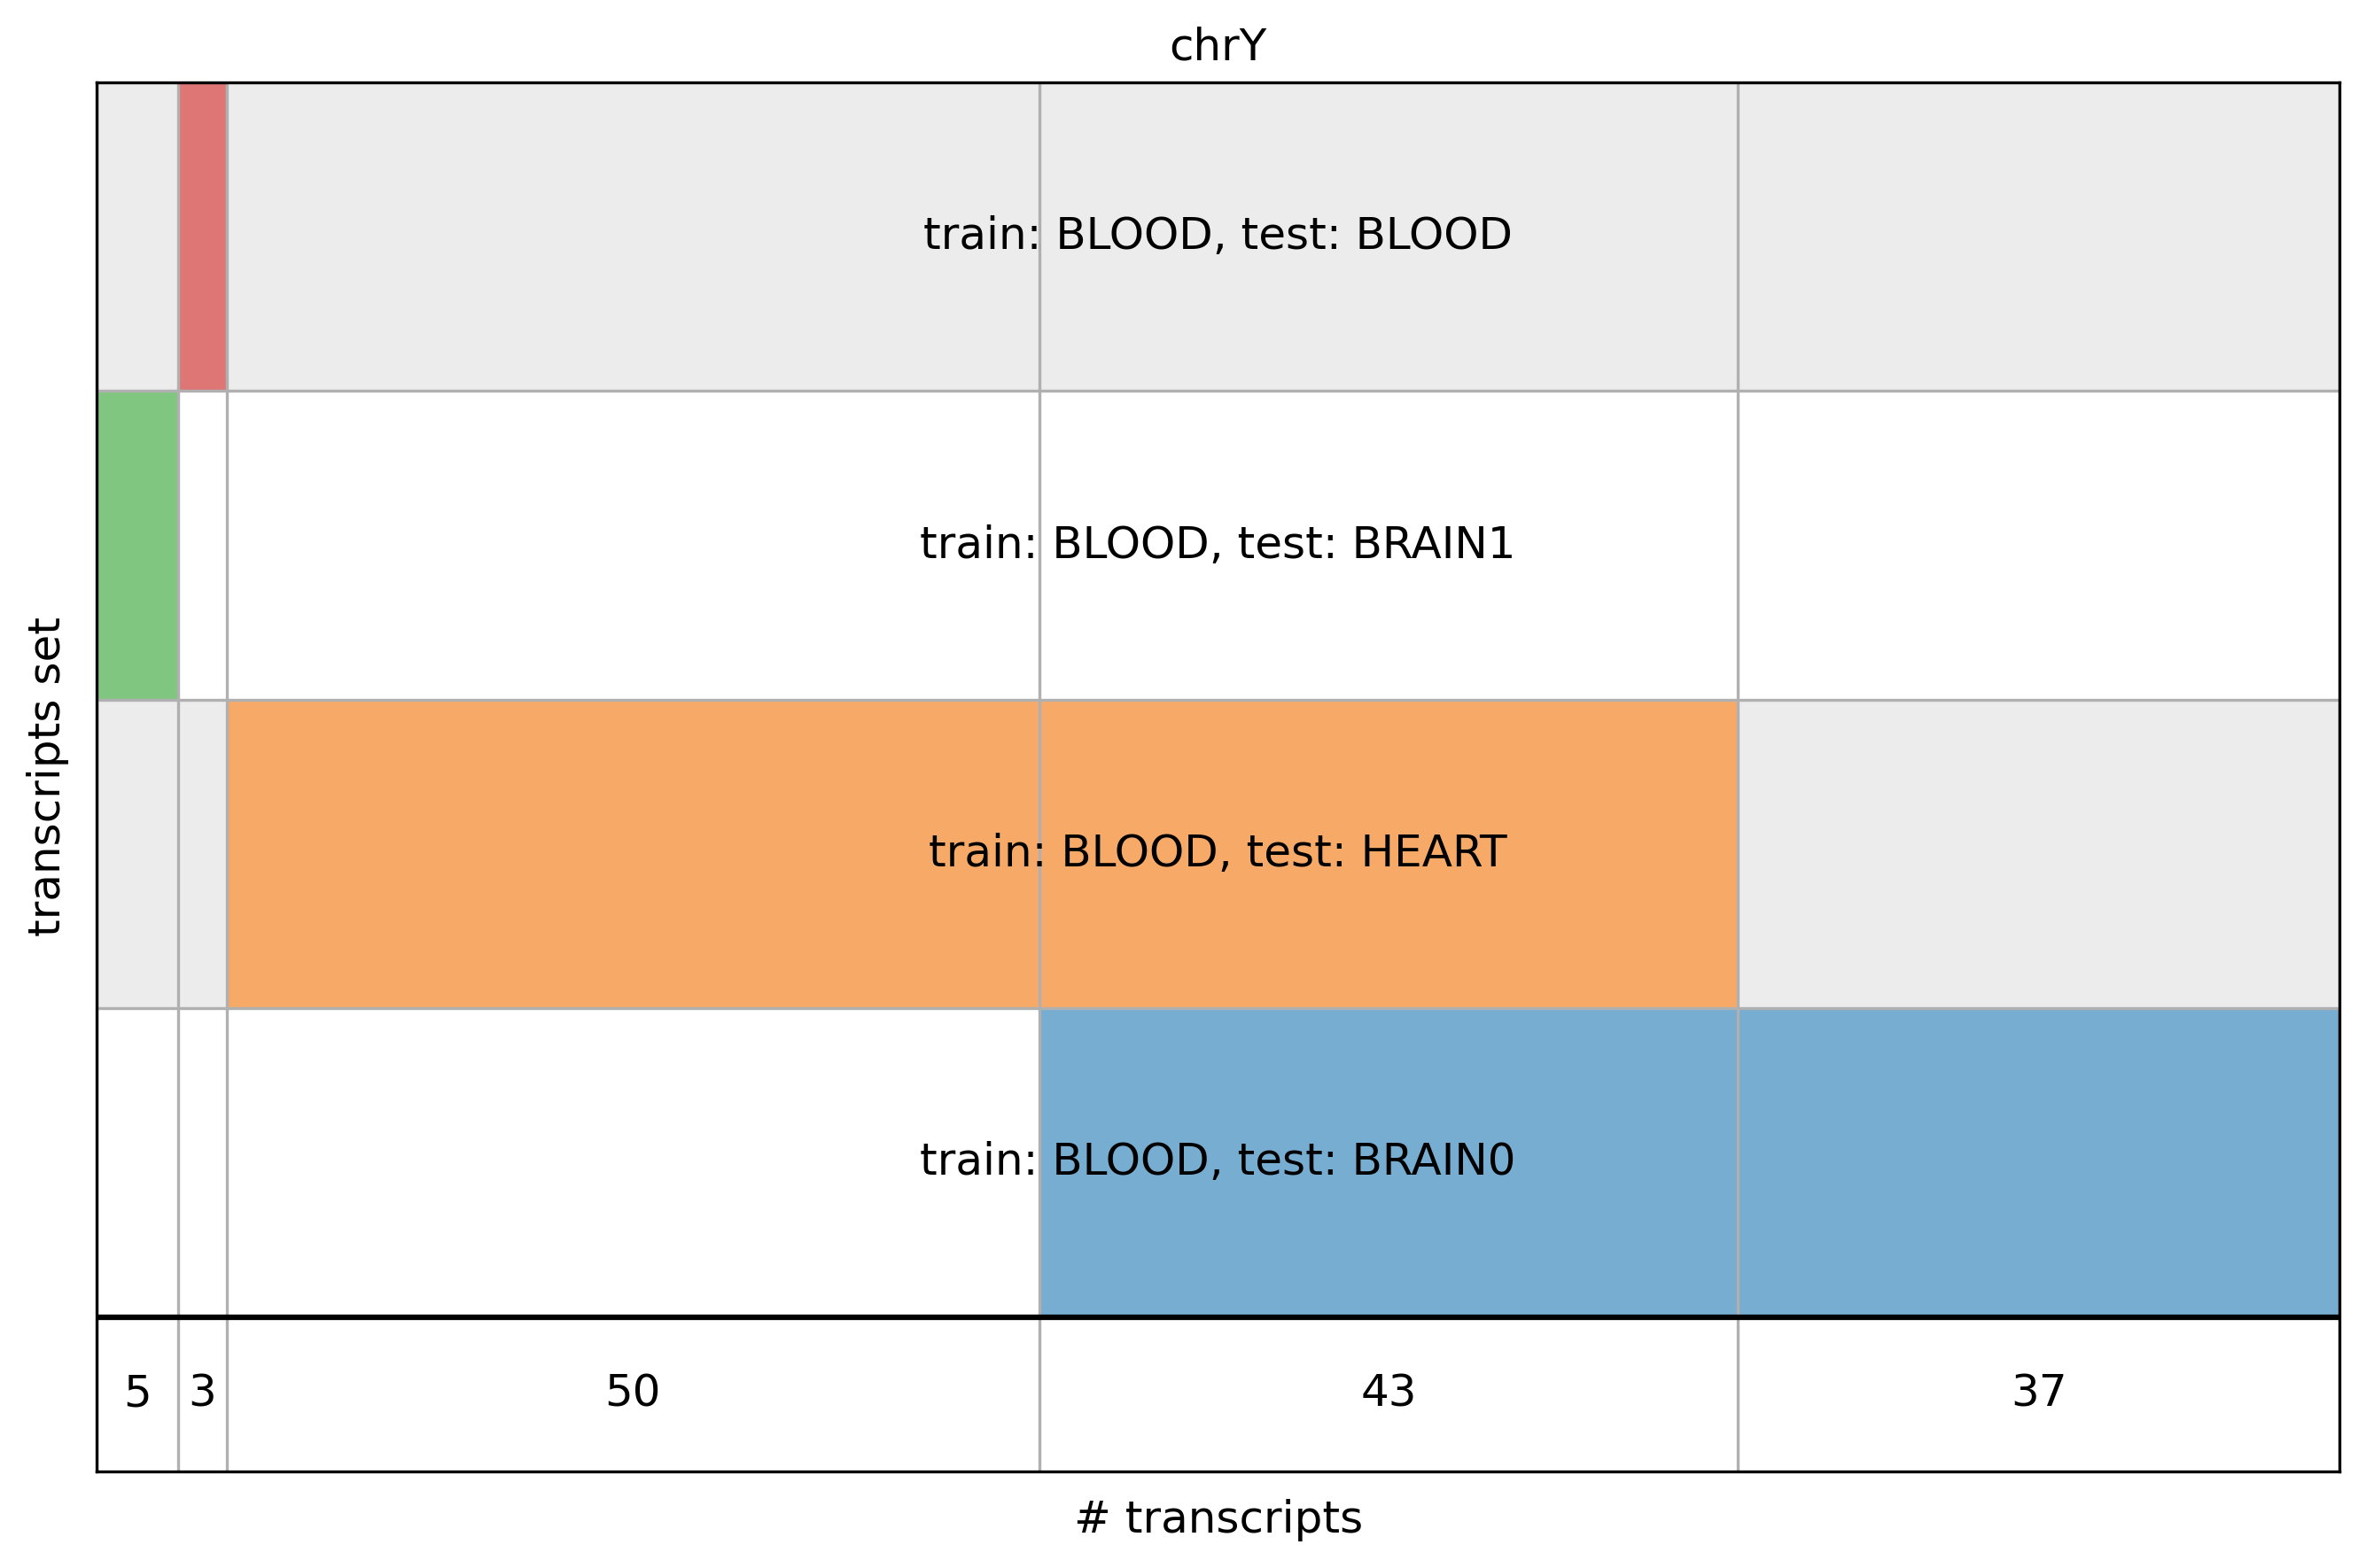

In [29]:
# chrXY_df = {
#     # "names": transcripts_list,
#     'BRAIN0': [],
#     'HEART': [], 
#     'BRAIN1': [],
#     'None': []
#     }
# fig, axs= plt.subplots()
# for transcript in transcripts_list:
#     for organ in ['BRAIN0', "HEART", "BRAIN1", 'None']:
        
#         if transcript in transcripts_dict[organ]['chrXY']:
#             chrXY_df[organ].append(True)
#         else:
#             chrXY_df[organ].append(False)
# chrXY_df = pd.DataFrame.from_dict(chrXY_df)
# 
# UpSet(chrXY_df, subset_size='count').plot()

# for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:

row_names = {
    "BRAIN0": "train: BLOOD, test: BRAIN0", 
    "HEART": "train: BLOOD, test: HEART", 
    "BRAIN1": "train: BLOOD, test: BRAIN1", 
    "BLOOD": "train: BLOOD, test: BLOOD",
}

sex = ['chrXY', 'chrX', 'chrY', 'autosome'][2]
test_dict = {}
for organ in ['BRAIN0', "HEART", "BRAIN1", 'BLOOD']:
    test_dict[row_names[organ]] = set(transcripts_dict[organ][sex].tolist())

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        # sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps',
        side_plots=False
        )
plt.title(sex)
plt.tight_layout()
g.axes['main'].set_xlabel('# transcripts')
g.axes['main'].set_ylabel('transcripts set')


print("Chromosomes: ", sex)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])
    # print(adata.var['gene_name'][list(g.chunks[el])])


Organ:  BRAIN1
['autosome'] : 
{'ENST00000565196.5', 'ENST00000308831.7', 'MSTRG.13450.7', 'ENST00000494573.6', 'MSTRG.12050.13', 'MSTRG.14706.28', 'MSTRG.5179.5', 'MSTRG.32512.1', 'ENST00000589005.5', 'ENST00000300184.8', 'ENST00000548200.5', 'ENST00000548305.5', 'ENST00000412260.5', 'MSTRG.11500.1', 'MSTRG.3806.9', 'ENST00000413366.8', 'MSTRG.23169.2', 'ENST00000375200.6', 'ENST00000582019.5', 'ENST00000466335.1', 'ENST00000337338.9', 'ENST00000246080.4', 'ENST00000684774.1', 'MSTRG.14482.3', 'MSTRG.21438.5', 'MSTRG.26990.1', 'MSTRG.27773.6', 'ENST00000507765.1', 'MSTRG.6368.4', 'MSTRG.3823.12', 'ENST00000476438.1', 'ENST00000581584.5', 'MSTRG.28032.1', 'ENST00000280187.11', 'ENST00000651342.1', 'MSTRG.20210.2', 'ENST00000357450.9', 'MSTRG.17797.1', 'ENST00000372476.8', 'ENST00000382545.5', 'ENST00000464587.2', 'MSTRG.21565.11', 'MSTRG.1857.1', 'MSTRG.20714.15', 'ENST00000372583.6', 'MSTRG.21565.12', 'MSTRG.16726.28', 'MSTRG.29554.27', 'MSTRG.20911.32', 'ENST00000624344.1', 'MSTRG.33

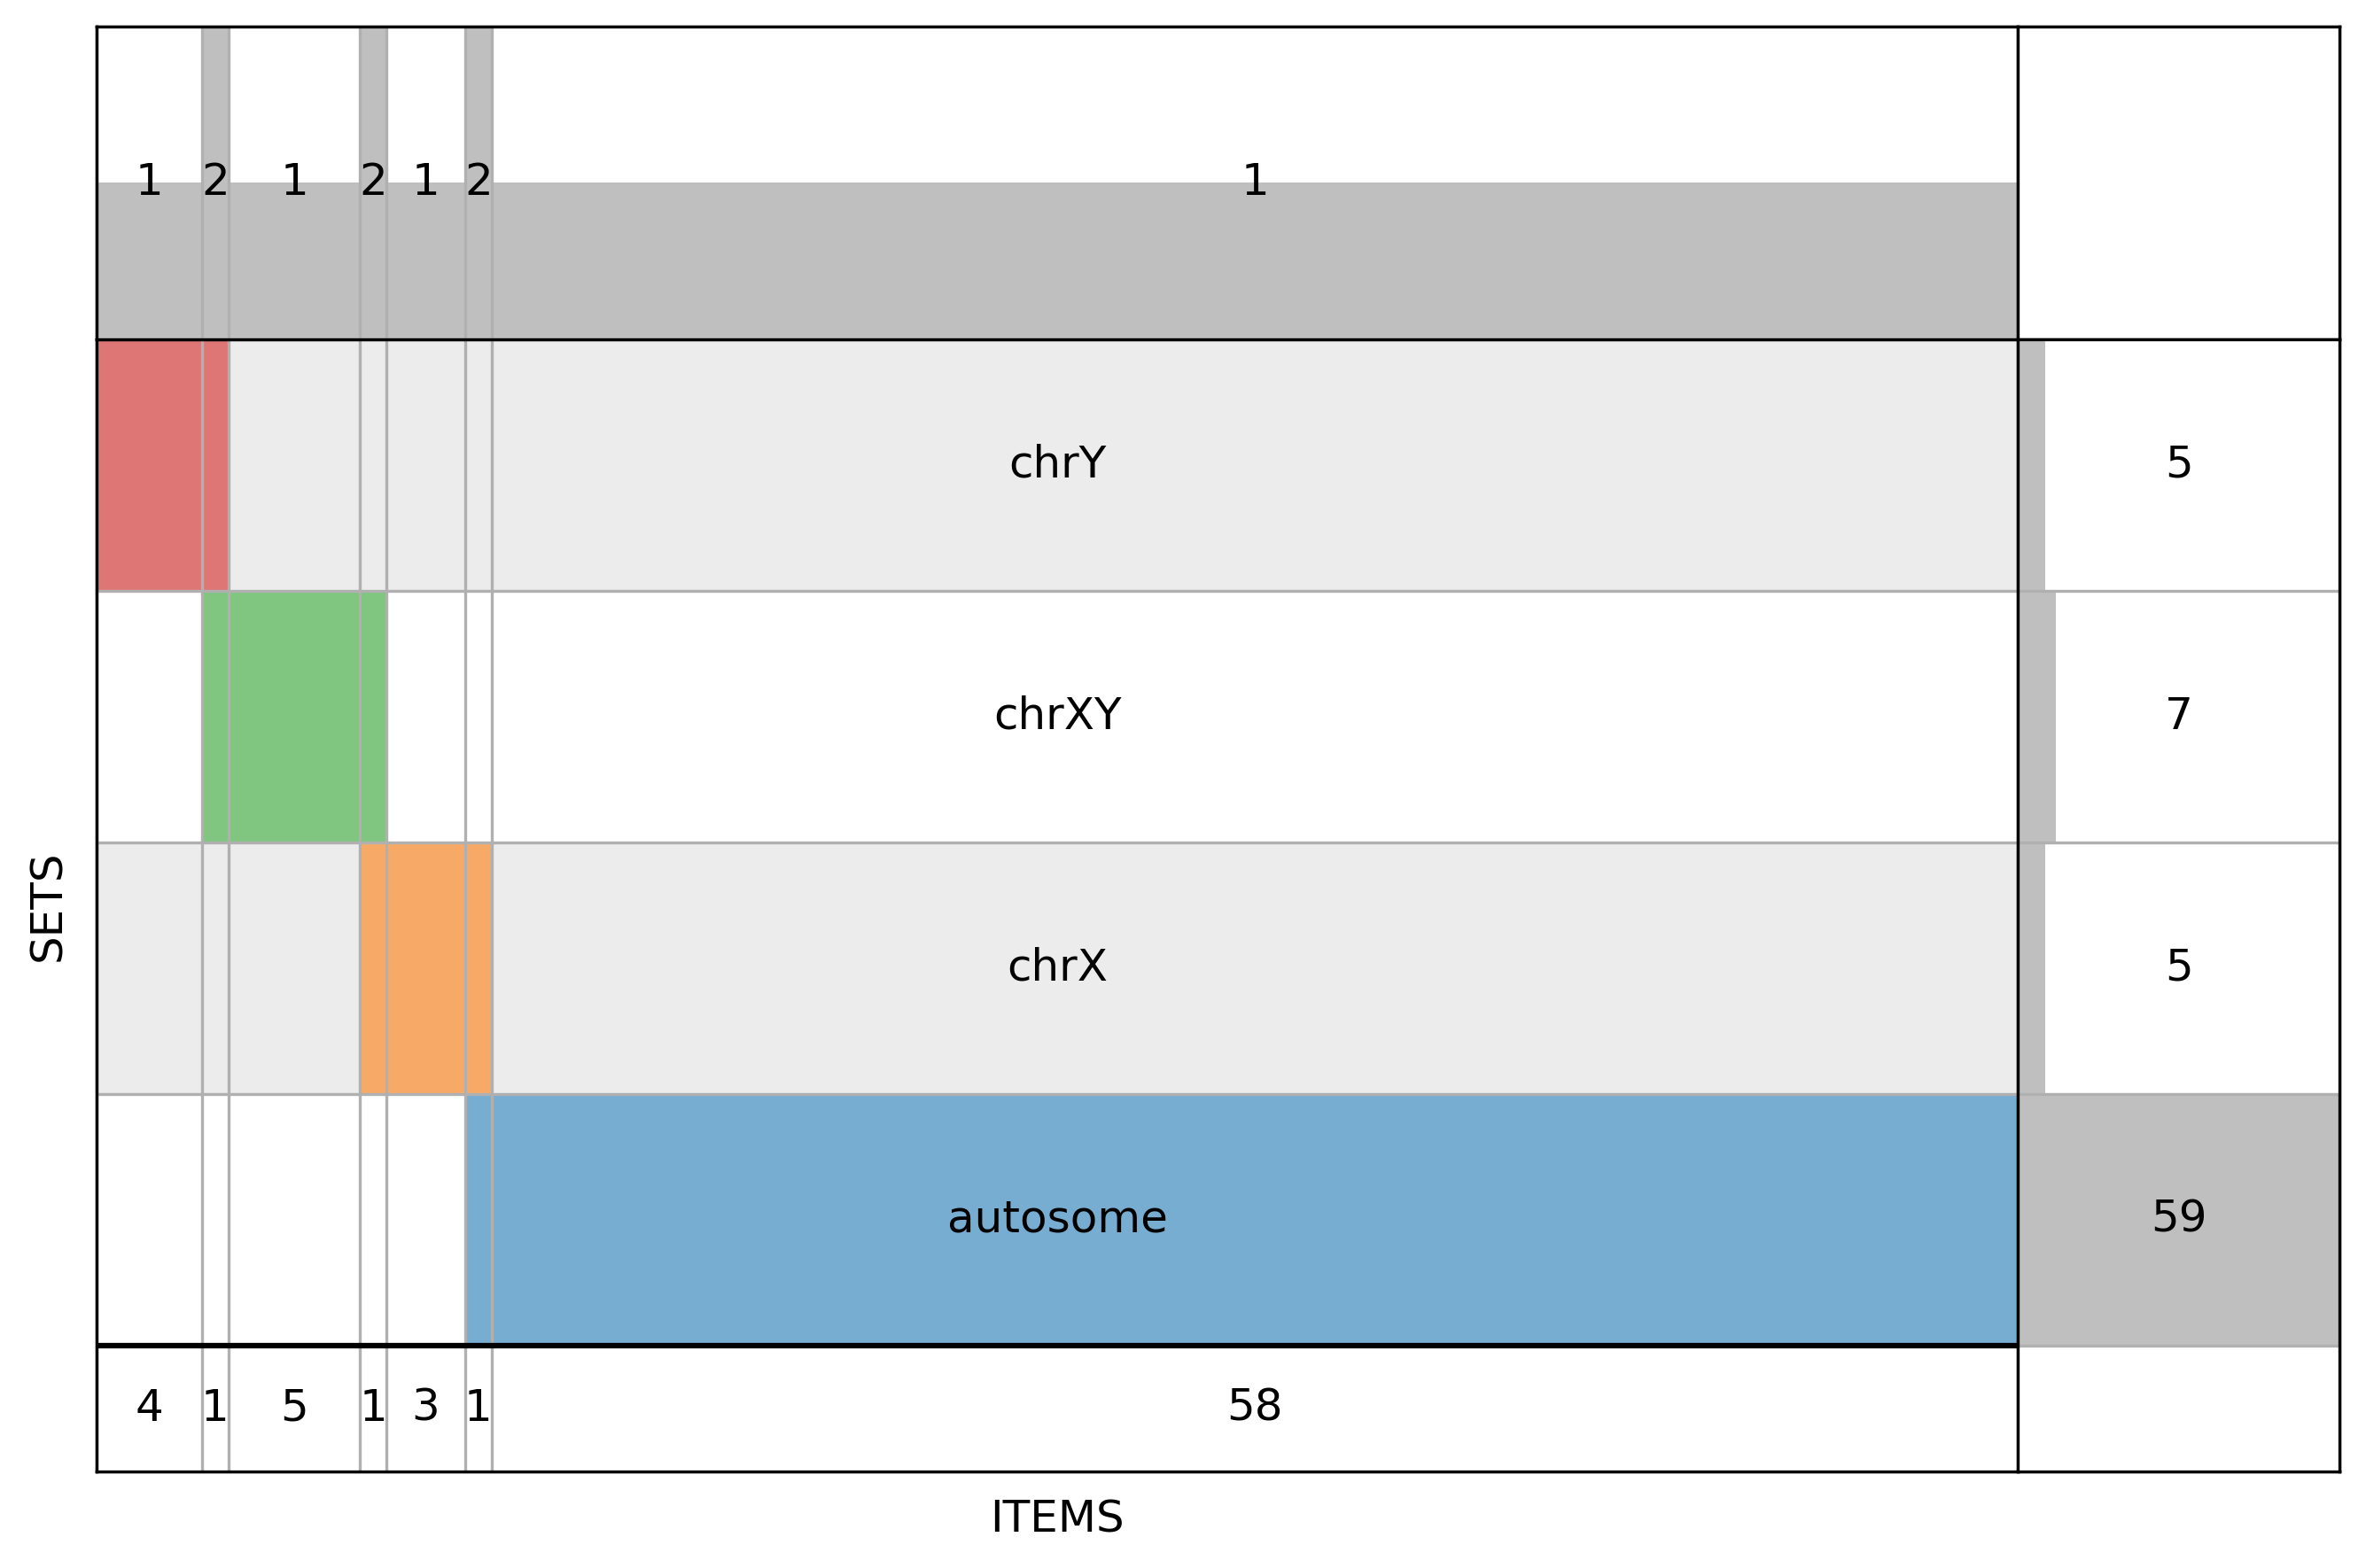

In [21]:
organ = ['BRAIN0', "HEART", "BRAIN1", 'None'][2]
test_dict = {}
for sex in ['chrXY', 'chrX', 'chrY', 'autosome']:
    test_dict[sex] = set(transcripts_dict[organ][sex].tolist())

# UpSet(from_contents(test_dict), show_counts=True).plot()

plt.figure(figsize=(9, 6), dpi=300)
g = supervenn(list(test_dict.values()), list(test_dict.keys()),
        sets_ordering="minimize gaps",
        chunks_ordering='minimize gaps')
plt.title(sex)
plt.tight_layout()

print("Organ: ", organ)
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)], ": ")
    print(g.chunks[el])

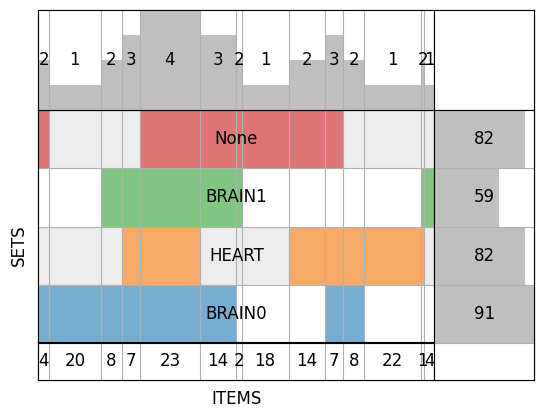

In [8]:
g = supervenn(list(test_dict.values()), list(test_dict.keys()), 
              sets_ordering=None)

In [9]:
for el in list(g.chunks.keys()):
    print(np.array(list(test_dict.keys()))[list(el)])

['BRAIN0']
['BRAIN1' 'None']
['HEART' 'None']
['BRAIN0' 'HEART' 'BRAIN1' 'None']
['BRAIN0' 'HEART' 'BRAIN1']
['None']
['BRAIN0' 'BRAIN1' 'None']
['HEART']
['BRAIN0' 'BRAIN1']
['BRAIN0' 'HEART' 'None']
['BRAIN0' 'HEART']
['BRAIN0' 'None']
['BRAIN1']
['HEART' 'BRAIN1']


In [10]:
np.array(list(test_dict.keys()))

array(['BRAIN0', 'HEART', 'BRAIN1', 'None'], dtype='<U6')